In [1]:
# Uncomment if running with Google Colab
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install pingouin
# !pip install scikit-posthocs
# !pip install nbformat --upgrade
# !pip install seaborn --upgrade
# !pip install researchpy

import pandas as pd
import tqdm
import warnings
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Assuming your CSV file is named "data.csv"

loc = "../data/experiments/" #change to your drive's equivalent to ../data/experiments

models = [
    'GPT2',
    'LLaMa2-7B',
    'Mistral-7B',
    'SOLAR-10-7B',
    'LLaMa3-8B',
    ]

subjects = [
    'abstract_algebra',
    'anatomy',
    'astronomy',
    'business_ethics',
    'clinical_knowledge',
    'college_biology',
    'college_chemistry',
    'college_computer_science',
    'college_mathematics',
    'college_medicine',
    'college_physics',
    'computer_security',
    'conceptual_physics',
    'econometrics',
    'electrical_engineering',
    'elementary_mathematics',
    'formal_logic',
    'global_facts',
    'high_school_biology',
    'high_school_chemistry',
    'high_school_computer_science',
    'high_school_european_history',
    'high_school_geography',
    'high_school_government_and_politics',
    'high_school_macroeconomics',
    'high_school_mathematics',
    'high_school_microeconomics',
    'high_school_physics',
    'high_school_psychology',
    'high_school_statistics',
    'high_school_us_history',
    'high_school_world_history',
    'human_aging',
    'human_sexuality',
    'international_law',
    'jurisprudence',
    'logical_fallacies',
    'machine_learning',
    'management',
    'marketing',
    'medical_genetics',
    'miscellaneous',
    'moral_disputes',
    'moral_scenarios',
    'nutrition',
    'philosophy',
    'prehistory',
    'professional_accounting',
    'professional_law',
    'professional_medicine',
    'professional_psychology',
    'public_relations',
    'security_studies',
    'sociology',
    'us_foreign_policy',
    'virology',
    'world_religions',
]

In [4]:
def get_df(loc, select_reduction=1):

  df = pd.read_csv(loc)

  df['stimulus_prob'] = df['stimulus_prob'].apply(lambda x: x.replace('nan', '0'))
  df['stimulus_prob']  = df['stimulus_prob'].apply(ast.literal_eval)



  df['population data'] = df.apply(
      lambda row: [2**t for t in row['stimulus_prob']],
      axis=1)

  # df['rank'] = df['rank'].astype('float')
  # df['typical'] = df.apply(
  #     lambda row: row['rank']<28, # returns true if the item is in the context
  #     axis=1)


  df['question'] = df['preamble'].apply(lambda x: x[0:-10])
  df['question'] = df.groupby('question', sort=False).ngroup()+1

  df['item'] = df['preamble'].apply(lambda x: x[-9])

  df = df.explode('population data')
  df['member id'] = df.groupby(['stimulus', 'item', 'subject', 'question'], sort=False).cumcount()+1
  df['population data'] = df['population data'].astype('float')


  return df



def get_df_cloze(loc, select_reduction=1):

  df = pd.read_csv(loc)

  df['stimulus_prob'] = df['stimulus_prob'].apply(lambda x: x.replace('nan', '0'))
  df['stimulus_prob']  = df['stimulus_prob'].apply(ast.literal_eval)



  df['population data'] = df.apply(
      lambda row: [2**t for t in row['stimulus_prob']],
      axis=1)



  df['question'] = df['preamble'].apply(lambda x: x[0:-10])
  df['question'] = df.groupby('question', sort=False).ngroup()+1

  df['item'] = df['stimulus']

  df = df.explode('population data')
  df['member id'] = df.groupby(['stimulus', 'item', 'subject', 'question'], sort=False).cumcount()+1
  df['population data'] = df['population data'].astype('float')


  return df

In [5]:
def get_answers(df):
  # get the correct answers
  answers = df.groupby(['model','question', 'item', 'subject'], sort=False)['is_correct'].aggregate('max').reset_index() # get rid of the population
  idx = answers.groupby(['model', 'question','subject'], sort=False)['is_correct'].idxmax() # get the indices that have a 1 for is_correct
  answers = answers.loc[idx] # get the correct answers
  answers['correct'] = answers['item']
  answers = answers[['model', 'question', 'subject', 'correct']]
  return answers


def get_guesses(df, method='mean'):
  guesses = df.groupby(['model', 'question', 'item', 'subject'], sort=False)['population data'].aggregate(method).reset_index() # aggregate over the population
  idx = guesses.groupby(['model', 'question','subject'], sort=False)['population data'].idxmax()
  guesses = guesses.loc[idx]
  results = guesses.merge(get_answers(df), on=['model', 'question', 'subject'])
  return results

def calc_accuracy_by_subject(df):
  df['accuracy'] = df['item']==df['correct']
  df['accuracy'] = df['accuracy'].astype(int)
  return df.groupby(['model', 'subject'])['accuracy'].aggregate('mean')


def calc_accuracy(df):
  return calc_accuracy_by_subject(df).groupby('model').aggregate('mean')


def get_accuracy(df, method='mean'):
  return calc_accuracy(get_guesses(df, method))


def get_accuracy_by_subject(df, method='mean'):
  guesses = get_guesses(df, method)
  return calc_accuracy_by_subject(guesses)


# def get_accuracy_auto(df, scaling=1.0, thresh=0):

#   # currently it seems that the maximum standard deviation is associated wth the best answer
#   # get the population guesses

#   std_vals = df.groupby(['question', 'subject'], sort=False)['population data'].aggregate('std').reset_index()
#   mean_std = std_vals['population data'].mean()
#   std_vals['use std'] = std_vals['population data'] < scaling*mean_std if thresh == 0 else std_vals['population data'] < scaling*thresh

#   guesses_std = df.groupby(['question', 'item', 'subject'], sort=False)['population data'].aggregate('std').reset_index() # aggregate over the population
#   guesses = df.groupby(['question', 'item', 'subject'], sort=False)['population data'].aggregate('mean').reset_index()

#   idx_std = guesses_std.groupby(['question','subject'], sort=False)['population data'].idxmax()
#   idx = guesses.groupby(['question','subject'], sort=False)['population data'].idxmax()
#   guesses = guesses.loc[idx]

#   for item in range(idx_std.shape[0]):
#     if std_vals.iloc[item]['use std']:
#       # print(guesses_std.loc[idx_std.iloc[item+1]])
#       guesses.iloc[item] = guesses_std.loc[idx_std.iloc[item]]

#   results = guesses.merge(get_answers(df), on=['question', 'subject'])

#   return np.round(100*results[results['item']==results['correct']].shape[0]/results.shape[0],2)

In [8]:
# load data for the population, base model, and base model cloze test

# loop through all models and calculate the per category correlation and significance with typicality
import plotly.graph_objects as go

# all = pd.DataFrame()
base_all = pd.DataFrame()
cloze_all = pd.DataFrame()


# for model in models:
#   for subject in subjects:
#     df = get_df(loc+'MMLU'+"/"+subject+'/'+model+"_pop50_results.csv")
#     df['model'] = model
#     all = pd.concat([all, df])

for model in models:
  for subject in subjects:
    df = get_df(loc+'MMLU_cf'+"/"+subject+'/'+model+"_base_results.csv")
    df['model'] = model
    base_all = pd.concat([base_all, df])


for model in models:
  for subject in subjects:
    df = get_df_cloze(loc+'MMLU_cloze'+"/"+subject+'/'+model+"_base_results.csv")
    df['model'] = model
    cloze_all = pd.concat([cloze_all, df])


In [9]:
# load data for the cf and cloze test base rate probabilities in a controlled scenario
base_baseRate = pd.DataFrame()
cloze_baseRate = pd.DataFrame()

for model in models:
  df = get_df(loc+'MMLU_control_cf'+'/'+model+"_base_results.csv")
  df['model'] = model
  base_baseRate = pd.concat([base_baseRate, df])

for model in models:
  df = get_df_cloze(loc+'MMLU_control_cloze'+'/'+model+"_base_results.csv")
  df['model'] = model
  cloze_baseRate = pd.concat([cloze_baseRate, df])

In [11]:
# load cloze data for the never-x MMLU datasets
options = ['A', 'B', 'C', 'D']
exclude_option_cloze_data = {}

for option in options:
  cloze_exclude_answer = pd.DataFrame()
  for model in models:
    for subject in subjects:
      df = get_df_cloze(loc+'MMLU_Nvr'+option+'_cloze'+"/"+subject+'/'+model+"_base_results.csv")
      df['model'] = model
      cloze_exclude_answer = pd.concat([cloze_exclude_answer, df])

  exclude_option_cloze_data[option] = cloze_exclude_answer


FileNotFoundError: [Errno 2] No such file or directory: '../data/experiments/MMLU_NvrB_cloze/abstract_algebra/GPT2_base_results.csv'

In [22]:
# load cf data for the never-x MMLU datasets
options = ['A', 'B', 'C', 'D']
exclude_option_cf_data = {}

for option in options:
  cf_exclude_answer = pd.DataFrame()
  for model in models:
    for subject in subjects:
      df = get_df(loc+'MMLU_Nvr'+option+'_cf'+"/"+subject+'/'+model+"_base_results.csv")
      df['model'] = model
      cf_exclude_answer = pd.concat([cf_exclude_answer, df])

  exclude_option_cf_data[option] = cf_exclude_answer


In [24]:
# data frames that are being loaded
# all #population data is not loaded
base_all #cf data
cloze_all #cloze data
base_baseRate #base rates for cf
cloze_baseRate #base rates for cloze
exclude_option_cf_data #cf data for never-x dataset versions
exclude_option_cloze_data #cloze data for never-x dataset versions

{'A':                                               preamble stimulus  is_correct  \
 0    Find the degree for the given field extension ...        A           0   
 1    Find the degree for the given field extension ...        B           0   
 2    Find the degree for the given field extension ...        C           0   
 3    Find the degree for the given field extension ...        D           1   
 4    Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...        A           0   
 ..                                                 ...      ...         ...   
 679  According to the Japanese origin myth, who giv...        D           0   
 680   The numen of Augustus referred to which of th...        A           0   
 681   The numen of Augustus referred to which of th...        B           1   
 682   The numen of Augustus referred to which of th...        C           0   
 683   The numen of Augustus referred to which of th...        D           0   
 
               subject          s

In [113]:
# get accuracies for all base cf answer options
this = get_guesses(base_all)
options = ['A', 'B', 'C', 'D']

# base_accuracies_by_options = calc_accuracy(this[this['correct']==options[0]]).reset_index()
# base_accuracies_by_options.rename(columns={'accuracy':'option'+options[0]+'accuracy'}, inplace=True)

base_accuracies_by_options = pd.concat(
    [calc_accuracy(this[this['correct']==option]).reset_index()
    for option in options])

base_accuracies_by_options['option'] = [option
                                        for option in options
                                        for j in range(base_accuracies_by_options['model'].unique().shape[0])]


temp = base_baseRate.groupby(['model','item'])['population data'].aggregate('mean').reset_index()
temp.rename(columns={'population data':'base cf rate', 'item':'option'}, inplace=True)
base_accuracies_by_options = pd.merge(base_accuracies_by_options,
                                      temp,
                                      on=['model', 'option'])

temp = cloze_baseRate.groupby(['model','item'])['population data'].aggregate('mean').reset_index()
temp.rename(columns={'population data':'base rate', 'item':'option'}, inplace=True)
base_accuracies_by_options = pd.merge(base_accuracies_by_options,
                                      temp,
                                      on=['model', 'option'])

base_accuracies_by_options.groupby('model')[['accuracy', 'base rate']].corr(method='pearson')

<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['item']==df['correct']
<ipython-input-25-c94f9371b486>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['accuracy'].astype(int)
<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

accuracy  base rate
model                                     
GPT2        accuracy   1.000000   0.675782
            base rate  0.675782   1.000000
LLaMa2-7B   accuracy   1.000000   0.037790
            base rate  0.037790   1.000000
LLaMa3-8B   accuracy   1.000000   0.640921
            base rate  0.640921   1.000000
Mistral-7B  accuracy   1.000000   0.595282
            base rate  0.595282   1.000000
SOLAR-10-7B accuracy   1.000000  -0.154736
            base rate -0.154736   1.000000

In [177]:
# get accuracies for all cloze answer options
this = get_guesses(cloze_all)
options = ['A', 'B', 'C', 'D']

# base_accuracies_by_options = calc_accuracy(this[this['correct']==options[0]]).reset_index()
# base_accuracies_by_options.rename(columns={'accuracy':'option'+options[0]+'accuracy'}, inplace=True)

cloze_accuracies_by_options = pd.concat(
    [calc_accuracy(this[this['correct']==option]).reset_index()
    for option in options])

cloze_accuracies_by_options['option'] = [option
                                        for option in options
                                        for j in range(cloze_accuracies_by_options['model'].unique().shape[0])]


temp = cloze_baseRate.groupby(['model','item'])['population data'].aggregate('mean').reset_index()
temp.rename(columns={'population data':'base rate', 'item':'option'}, inplace=True)

cloze_accuracies_by_options = pd.merge(cloze_accuracies_by_options,
                                      temp,
                                      on=['model', 'option'])

cloze_accuracies_by_options.groupby('model')[['accuracy', 'base rate']].corr(method='pearson')


<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['item']==df['correct']
<ipython-input-25-c94f9371b486>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['accuracy'].astype(int)
<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

accuracy  base rate
model                                     
GPT2        accuracy   1.000000   0.967970
            base rate  0.967970   1.000000
LLaMa2-7B   accuracy   1.000000   0.265789
            base rate  0.265789   1.000000
LLaMa3-8B   accuracy   1.000000   0.706133
            base rate  0.706133   1.000000
Mistral-7B  accuracy   1.000000   0.982498
            base rate  0.982498   1.000000
SOLAR-10-7B accuracy   1.000000   0.978357
            base rate  0.978357   1.000000

<Axes: xlabel='model', ylabel="('accuracy', 'base rate')">

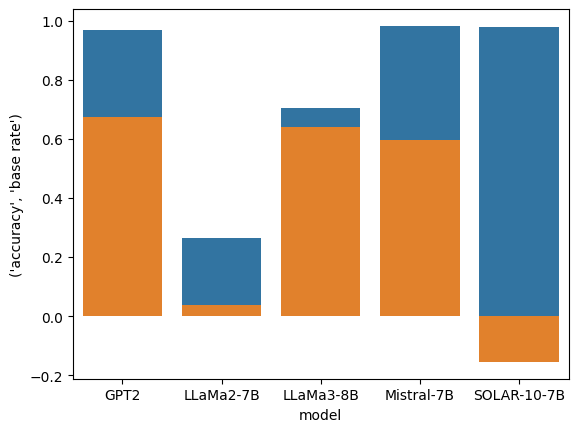

In [114]:
temp = cloze_accuracies_by_options.groupby('model')[['accuracy','base rate']].corr().unstack().iloc[:,1].reset_index()
sns.barplot(x='model', y=('accuracy','base rate'), data=temp)

temp = base_accuracies_by_options.groupby('model')[['accuracy','base rate']].corr().unstack().iloc[:,1].reset_index()
sns.barplot(x='model', y=('accuracy','base rate'), data=temp)

In [272]:
for model in models:
  this = get_guesses(all, method='max')
  print('population cf all', subject, calc_accuracy(this))
  print('population cf excluding correct=A', subject, calc_accuracy(this[this['correct']!='A']))

population cf all world_religions 29.24
population cf excluding correct=A world_religions 28.44


In [271]:
for model in models:
  this = get_guesses(base_all)
  print('base cf all', subject, calc_accuracy(this))
  print('base cf excluding correct=A', subject, calc_accuracy(this[this['correct']!='A']))

base cf all world_religions 33.43
base cf excluding correct=A world_religions 27.87


In [43]:
for model in models:
  this = get_guesses(cloze_all, method='max')
  print('base cloze all', calc_accuracy(this))
  print('base cloze excluding correct=A', calc_accuracy(this[this['correct']=='D']))

base cloze all 38.44
base cloze excluding correct=A 16.37


In [ ]:
# calculate accuracy for questions that have the specific correct answer

import matplotlib.pyplot as plt

options = ['A', 'B', 'C', 'D']

# this = get_guesses(all)
# new['accuracy pop'] = calc_accuracy_by_subject(this[this['correct']!='A'])

guesses_base_all = get_guesses(base_all)
guesses_cloze_all = get_guesses(cloze_all)

for option in options:

  new = pd.DataFrame()
  new['accuracy base counter'] = calc_accuracy_by_subject(guesses_base_all[guesses_base_all['correct']==option])
  new['accuracy base cloze'] = calc_accuracy_by_subject(guesses_cloze_all[guesses_cloze_all['correct']==option])

  new.reset_index(inplace=True)
  new.rename(columns={'index':'subject'}, inplace=True)

  ax = new.plot(kind='bar', x='subject', rot=70, figsize=(20,5))
  plt.xticks(ha='right')
  plt.show()

In [182]:
# get accuracies for all cloze answer options by subject
# this = get_guesses(cloze_all)
options = ['A', 'B', 'C', 'D']

cloze_accuracies_by_options_by_subject = pd.concat(
    [calc_accuracy_by_subject(this[this['correct']==option]).reset_index()
    for option in options])

cloze_accuracies_by_options_by_subject['option'] = [option
                                        for option in options
                                        for j in range(cloze_accuracies_by_options_by_subject['subject'].unique().shape[0])
                                        for j in range(cloze_accuracies_by_options_by_subject['model'].unique().shape[0])]



# cloze_accuracies_by_options_by_subject.groupby(['model','option'])['accuracy'].aggregate('mean').reset_index()
cloze_accuracies_by_options_by_subject

<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['item']==df['correct']
<ipython-input-25-c94f9371b486>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['accuracy'].astype(int)
<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,model,subject,accuracy,option
0,GPT2,abstract_algebra,1.000000,A
1,GPT2,anatomy,1.000000,A
2,GPT2,astronomy,1.000000,A
3,GPT2,business_ethics,1.000000,A
4,GPT2,clinical_knowledge,0.982456,A
...,...,...,...,...
280,SOLAR-10-7B,security_studies,0.704082,D
281,SOLAR-10-7B,sociology,0.740741,D
282,SOLAR-10-7B,us_foreign_policy,0.840000,D
283,SOLAR-10-7B,virology,0.718750,D


In [196]:
# get accuracies for all cloze answer options by subject
this = get_guesses(base_all)
options = ['A', 'B', 'C', 'D']

cf_accuracies_by_options_by_subject = pd.concat(
    [calc_accuracy_by_subject(this[this['correct']==option]).reset_index()
    for option in options])

cf_accuracies_by_options_by_subject['option'] = [option
                                        for option in options
                                        for j in range(cf_accuracies_by_options_by_subject['subject'].unique().shape[0])
                                        for j in range(cf_accuracies_by_options_by_subject['model'].unique().shape[0])]



# cloze_accuracies_by_options_by_subject.groupby(['model','option'])['accuracy'].aggregate('mean').reset_index()
cf_accuracies_by_options_by_subject

<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['item']==df['correct']
<ipython-input-25-c94f9371b486>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accuracy'] = df['accuracy'].astype(int)
<ipython-input-25-c94f9371b486>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,model,subject,accuracy,option
0,GPT2,abstract_algebra,0.545455,A
1,GPT2,anatomy,0.160000,A
2,GPT2,astronomy,0.481481,A
3,GPT2,business_ethics,0.833333,A
4,GPT2,clinical_knowledge,0.263158,A
...,...,...,...,...
280,SOLAR-10-7B,security_studies,0.367347,D
281,SOLAR-10-7B,sociology,0.555556,D
282,SOLAR-10-7B,us_foreign_policy,0.480000,D
283,SOLAR-10-7B,virology,0.468750,D


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  ).format(gutter_prop)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  ).format(gutter_prop)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  ).format(gutter_prop)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  ).format(gutter_prop)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of th

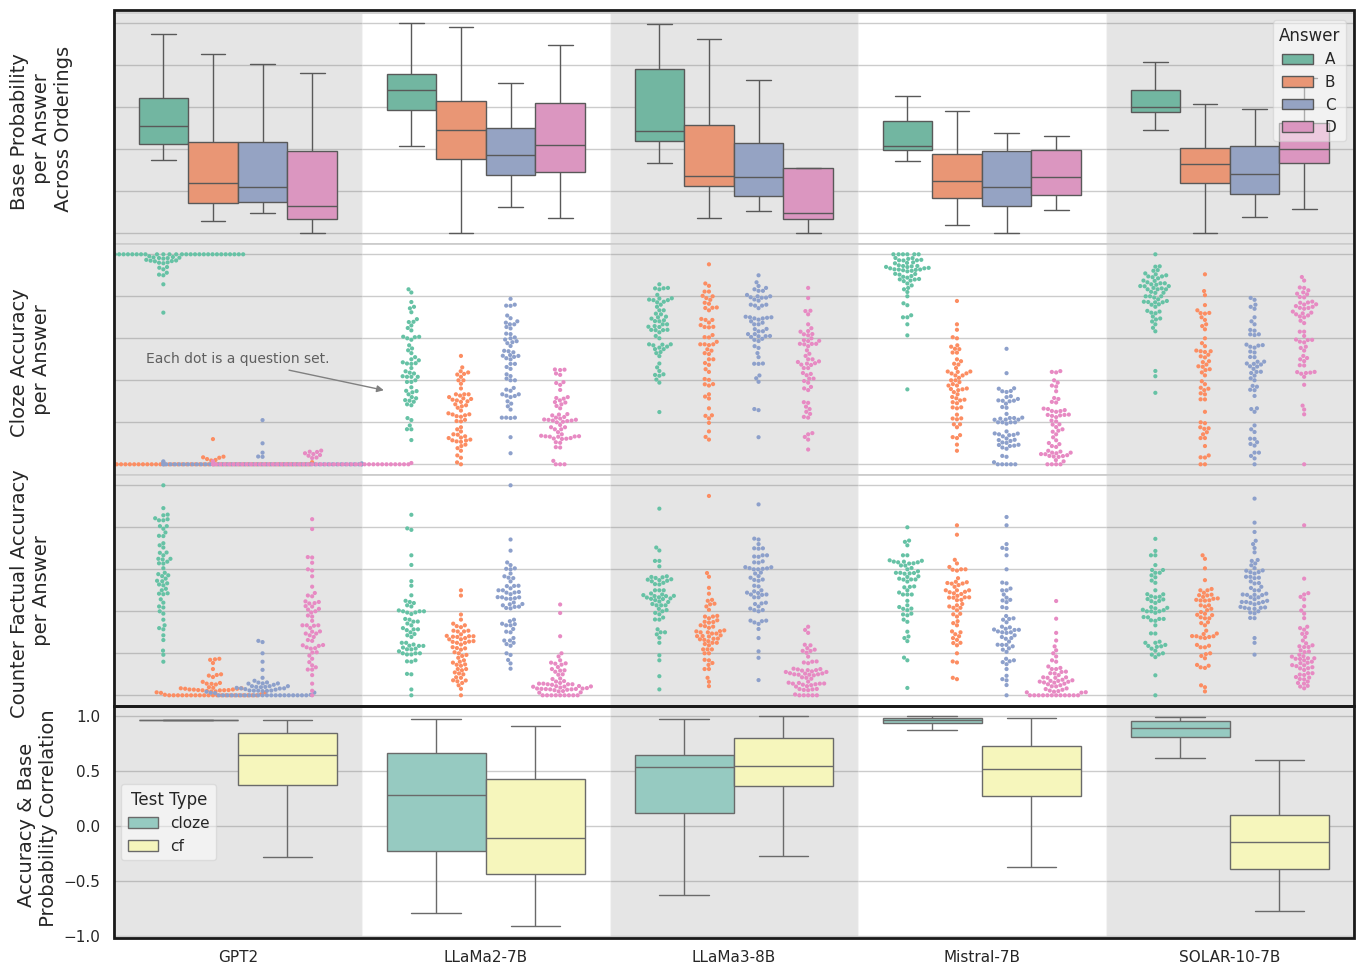

In [320]:
import matplotlib.pyplot as plt

def alt_bands(ax=None, highlight = None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    count = 0
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        if count == highlight:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
        else:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
        count+= 1
    ax.set_xlim(x_left, x_right)

fig, axs = plt.subplots(4, 1, figsize=(16,12), height_ratios=[5,5,5,5])

normalized = cloze_baseRate
normalized['probability'] = normalized.groupby('model')['population data'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

sns.set(style="whitegrid")
sns.boxplot(x = "model",
            hue='item',
            y='probability',
            data=normalized.sort_values(['model','item']),
            ax=axs[0],
            palette='Set2',
            showfliers=False,
            # dodge=True,
            )

axs[0].set(yticklabels=[])
plt.margins(x=0.01)
plt.subplots_adjust(hspace = 0)

# normalized = base_baseRate
# normalized['normalized'] = normalized.groupby('model')['population data'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))


sns.swarmplot(x = "model",
            hue='option',
            y='accuracy',
            data=cloze_accuracies_by_options_by_subject.sort_values(['model','option']),
            ax=axs[1],
            palette='Set2',
            # showfliers=False,
            legend=False,
            dodge=True,
            size=3,
            )
axs[1].set(yticklabels=[])

sns.swarmplot(x = "model",
            hue='option',
            y='accuracy',
            data=cf_accuracies_by_options_by_subject.sort_values(['model','option']),
            ax=axs[2],
            palette='Set2',
            # showfliers=False,
            legend=False,
            dodge=True,
            size=3,
            )
axs[2].set(yticklabels=[])

br = cloze_baseRate.groupby(['model','item'])['population data'].aggregate('mean').reset_index()
br.rename(columns={'population data':'base rate', 'item':'option'}, inplace=True)

temp = pd.merge(cloze_accuracies_by_options_by_subject,
                                      br,
                                      on=['model', 'option'])

temp = temp.groupby(['model', 'subject'])[['accuracy','base rate']].corr().unstack().iloc[:,1].reset_index()
temp['type'] = 'cloze'

temp1 = pd.merge(cf_accuracies_by_options_by_subject,
                                      br,
                                      on=['model', 'option'])

temp1 = temp1.groupby(['model', 'subject'])[['accuracy','base rate']].corr().unstack().iloc[:,1].reset_index()
temp1['type'] = 'cf'

temp = pd.concat([temp, temp1]).reset_index()
temp['correlation'] = temp[('accuracy','base rate')]

sns.boxplot(x = "model",
            hue='type',
            y='correlation',
            data=temp.sort_values('model'),
            ax=axs[3],
            showfliers=False,
            palette='Set3',
            )


axs[0].set_ylabel('Base Probability \n per Answer \n Across Orderings \n ', size=14)
axs[1].set_ylabel('Cloze Accuracy \n per Answer \n \n ', size=14)
axs[2].set_ylabel('Counter Factual Accuracy \n per Answer \n \n ', size=14)
axs[3].set_ylabel('Accuracy & Base \n Probability Correlation', size=14)

alt_bands(axs[0], highlight=8)
alt_bands(axs[1], highlight=8)
alt_bands(axs[2], highlight=8)
alt_bands(axs[3], highlight=8)

plt.xlabel("")

axs[1].annotate('Each dot is a question set.',
                  xy=(0.6, 0.35), xycoords='data', alpha=0.7,
                  xytext=(0, 0.5), textcoords='data',
                  size=10, va="center", ha="center",
                  # bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  fc="gray", ec='gray'))

axs[0].legend(title='Answer', loc='upper right', fancybox=True, framealpha=0.5, bbox_to_anchor=(1, 1),ncol=1)

axs[3].legend(title='Test Type', loc='lower left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 0.3),ncol=1)


rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.125, 0.3025), 0.775, 0.58, fill=False, color="k", lw=2,
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0.125, 0.109), 0.775, 0.1935, fill=False, color="k", lw=2,
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])

# plt.tight_layout()
plt.show()

In [ ]:
cloze_mean_base_rate = cloze_baseRate.groupby('item')['population data'].aggregate('mean').reset_index()


options = ['A', 'B', 'C', 'D']
accuracy = []
this = get_guesses(cloze_all)
for item in options:
  accuracy.append(calc_accuracy(this[this['correct']==item]))
  print(item, accuracy[-1], cloze_mean_base_rate[cloze_mean_base_rate['item']==item]['population data'])

cloze_mean_base_rate['accuracy'] = accuracy
cloze_mean_base_rate['base rate'] = cloze_mean_base_rate['population data']

print(cloze_mean_base_rate[['accuracy','base rate']].corr(method='pearson'))

In [ ]:
cf_mean_base_rate = base_baseRate.groupby('item')['population data'].aggregate('mean').reset_index()

options = ['A', 'B', 'C', 'D']
# options =[0,1,2,3]
accuracy = []
this = get_guesses(base_all)
for item in options:
  accuracy.append(calc_accuracy(this[this['correct']==item]))
  print(item, accuracy[-1], cf_mean_base_rate[cf_mean_base_rate['item']==item]['population data'])

cf_mean_base_rate['accuracy'] = accuracy
# cf_mean_base_rate['base rate'] = cf_mean_base_rate['population data']
cf_mean_base_rate['base rate'] = cloze_mean_base_rate['base rate']

print(cf_mean_base_rate[['accuracy','base rate']].corr(method='pearson'))

In [324]:
cf_acc = []
for model in models:
  print(model)
  for option in options:
    this = exclude_option_cf_data[option]
    this = get_guesses(this[this['model']==model])
    cf_acc.append(calc_accuracy_by_subject(this).mean())
    print('never '+option, cf_acc[-1])

GPT2
never A 0.1344634187363553
never B 0.3257149576018905
never C 0.3203115703480449
never D 0.22742744167741955
LLaMa2-7B
never A 0.23774085456972802
never B 0.2702504653162585
never C 0.20115642235970732
never D 0.3082319608399432
Mistral-7B
never A 0.10726988279099664
never B 0.31664684721901243
never C 0.30415234695704135
never D 0.3405357689676855
SOLAR-10-7B
never A 0.11269094751053854
never B 0.34033642209857756
never C 0.32141195455357996
never D 0.3636791604753436
LLaMa3-8B
never A 0.34098061048098244
never B 0.40168197657822413
never C 0.3143866900237531
never D 0.44985630535867616


In [325]:
cloze_acc = []
for model in models:
  print(model)
  for option in options:
    this = exclude_option_cloze_data[option]
    this = get_guesses(this[this['model']==model])
    cloze_acc.append(calc_accuracy_by_subject(this).mean())
    print('never '+option, cloze_acc[-1])

GPT2
never A 0.007386972676768832
never B 0.3356796693282497
never C 0.33270768609736673
never D 0.3239476003527513
LLaMa2-7B
never A 0.31422998252213175
never B 0.39754568562699366
never C 0.3460810070426488
never D 0.4169974030497581
Mistral-7B
never A 0.27332649266939124
never B 0.44469141644192417
never C 0.4678952972254474
never D 0.5117349024963054
SOLAR-10-7B
never A 0.5034030366627681
never B 0.6254392459094337
never C 0.6078522206743112
never D 0.593734204214607
LLaMa3-8B
never A 0.5601140424292006
never B 0.5859946067272762
never C 0.5713825844698375
never D 0.6285028800636879


In [328]:
for model in models:
  print(model)
  this = cloze_all
  this = get_guesses(this[this['model']==model])
  print(calc_accuracy_by_subject(this).mean())

GPT2
0.23134889356036223
LLaMa2-7B
0.3483084999789466
Mistral-7B
0.39257875483216875
SOLAR-10-7B
0.5635683209733061
LLaMa3-8B
0.5742260372773242


In [327]:
for model in models:
  print(model)
  this = base_all[option]
  this = get_guesses(this[this['model']==model])
  print(calc_accuracy_by_subject(this).mean())

GPT2
0.24810999702332356
LLaMa2-7B
0.2595217087027159
Mistral-7B
0.3383590809464352
SOLAR-10-7B
0.3659923011662261
LLaMa3-8B
0.34073185279750423
